In [2]:
import os
from collections import defaultdict

label_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN/labels/train",
    "VAL": "UA-DETRAC_UPD_ANN/labels/val",
}

image_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN/images/train",
    "VAL": "UA-DETRAC_UPD_ANN/images/val",
}

In [5]:
def exist_labels(label_dirs):
    class_counts = defaultdict(int)

    for split in ["TRAIN", "VAL"]:
        for filename in os.listdir(label_dirs[split]):
            if filename.endswith(".txt"):
                with open(os.path.join(label_dirs[split], filename), "r") as f:
                    for line in f:
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1

    print("Распределение классов:", dict(sorted(class_counts.items())))

In [6]:
exist_labels(label_dirs)

Распределение классов: {0: 5331, 1: 9487, 2: 601829, 3: 64726, 4: 46162, 5: 4560, 7: 1738, 8: 512577}


In [3]:
output_img_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN_NO_MASK/images/train",
    "VAL": "UA-DETRAC_UPD_ANN_NO_MASK/images/val",
}
output_label_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN_NO_MASK/labels/train",
    "VAL": "UA-DETRAC_UPD_ANN_NO_MASK/labels/val",
}

In [13]:
import os
import cv2
import shutil

for split in ["TRAIN", "VAL"]:
    os.makedirs(output_img_dirs[split], exist_ok=True)
    os.makedirs(output_label_dirs[split], exist_ok=True)

def process_dataset(image_dir, label_dir, output_dir, output_label_dir):
    for filename in os.listdir(image_dir):
        if not filename.endswith(".jpg"):
            continue

        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
        output_path = os.path.join(output_dir, filename)
        output_label_path = os.path.join(output_label_dir, filename.replace(".jpg", ".txt"))

        image = cv2.imread(image_path)

        if not os.path.exists(label_path):
            shutil.copy(image_path, output_path)
            continue

        with open(label_path, "r") as f:
            lines = f.readlines()

        h, w, _ = image.shape
        new_lines = []

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, bbox_w, bbox_h = map(float, parts[1:])

            x1 = int((x_center - bbox_w / 2) * w)
            y1 = int((y_center - bbox_h / 2) * h)
            x2 = int((x_center + bbox_w / 2) * w)
            y2 = int((y_center + bbox_h / 2) * h)

            if class_id in [7, 8]:
                image[y1:y2, x1:x2] = 0
            else:
                new_lines.append(line)

        cv2.imwrite(output_path, image)

        if new_lines:
            with open(output_label_path, "w") as f:
                f.writelines(new_lines)
        else:
            if os.path.exists(output_label_path):
                os.remove(output_label_path)


process_dataset(image_dirs["TRAIN"], label_dirs["TRAIN"], output_img_dirs["TRAIN"], output_label_dirs["TRAIN"])
process_dataset(image_dirs["VAL"], label_dirs["VAL"], output_img_dirs["VAL"], output_label_dirs["VAL"])

print("process done")

process done


In [15]:
def count_files(image_dir, label_dir):
    image_count = len([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    label_count = len([f for f in os.listdir(label_dir) if f.endswith(".txt")])
    return image_count, label_count

train_images_orig, train_labels_orig = count_files(image_dirs["TRAIN"], label_dirs["TRAIN"])
val_images_orig, val_labels_orig = count_files(image_dirs["VAL"], label_dirs["VAL"])

train_images_new, train_labels_new = count_files(output_img_dirs["TRAIN"], output_label_dirs["TRAIN"])
val_images_new, val_labels_new = count_files(output_img_dirs["VAL"], output_label_dirs["VAL"])

assert train_images_orig == train_images_new, f"TRAIN images: {train_images_orig} -> {train_images_new}"
assert val_images_orig == val_images_new, f"VAL images: {val_images_orig} -> {val_images_new}"
assert train_labels_orig >= train_labels_new, f"TRAIN labels: {train_labels_orig} -> {train_labels_new}"
assert val_labels_orig >= val_labels_new, f"VAL labels: {val_labels_orig} -> {val_labels_new}"

In [16]:
exist_labels(output_label_dirs)

Распределение классов: {0: 5331, 1: 9487, 2: 601829, 3: 64726, 4: 46162, 5: 4560}


In [17]:
import random
import matplotlib.pyplot as plt

class_names = {
    0: "bicycle",
    1: "motorcycle",
    2: "car",
    3: "transporter (van)",
    4: "bus",
    5: "truck (others)"
}

def draw_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        print("No label file found for this image")
        return image

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, bbox_w, bbox_h = map(float, parts[1:])

        x1 = int((x_center - bbox_w / 2) * w)
        y1 = int((y_center - bbox_h / 2) * h)
        x2 = int((x_center + bbox_w / 2) * w)
        y2 = int((y_center + bbox_h / 2) * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = class_names.get(class_id, "Unknown")
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

def draw_random_image(output_img_dirs):
    val_images = os.listdir(output_img_dirs["VAL"])
    random_image = random.choice(val_images)
    test_image_path = os.path.join(output_img_dirs["VAL"], random_image)
    test_label_path = os.path.join(output_label_dirs["VAL"], random_image.replace(".jpg", ".txt"))

    processed_image = draw_bboxes(test_image_path, test_label_path)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

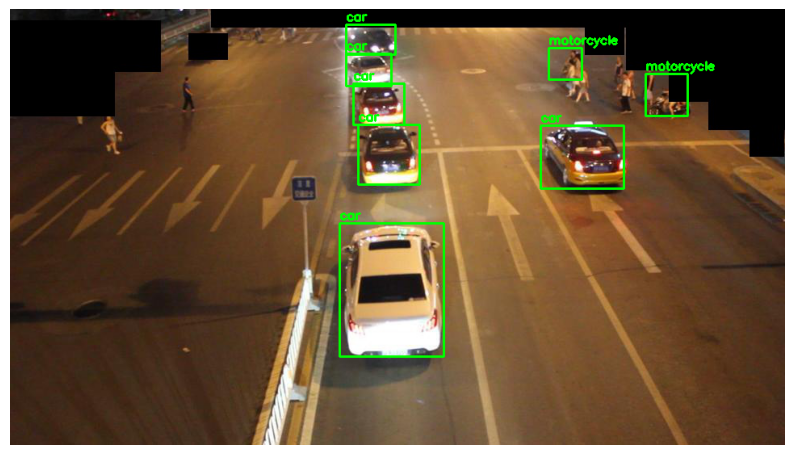

In [18]:
draw_random_image(output_img_dirs)

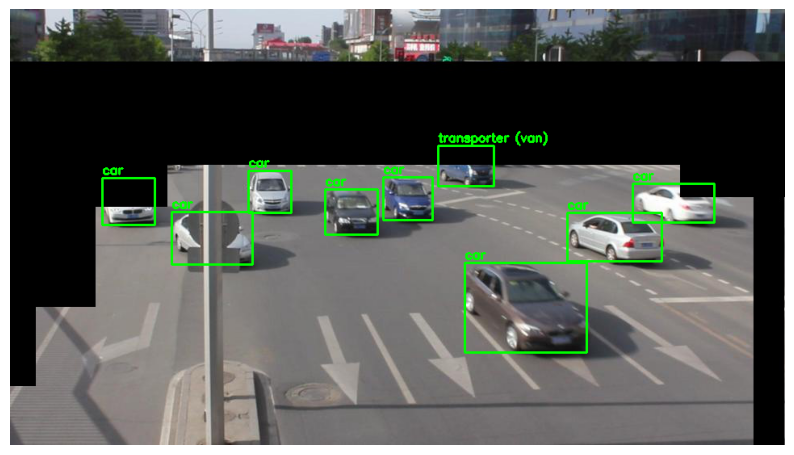

In [20]:
draw_random_image(output_img_dirs)

In [30]:
new_dataset_path = "UA-DETRAC_UPD_ANN_NO_MASK_MIN"
new_image_dir = os.path.join(new_dataset_path, "images")
new_label_dir = os.path.join(new_dataset_path, "labels")

for split in ["train", "val"]:
    os.makedirs(os.path.join(new_image_dir, split), exist_ok=True)
    os.makedirs(os.path.join(new_label_dir, split), exist_ok=True)


priority_classes = {0, 1, 3, 4, 5}

image_class_map = {}

for split in ["TRAIN", "VAL"]:
    for filename in os.listdir(label_dirs[split]):
        if filename.endswith(".txt"):
            with open(os.path.join(label_dirs[split], filename), "r") as f:
                classes = {int(line.split()[0]) for line in f.readlines()}
                image_class_map[(split, filename.replace(".txt", ".jpg"))] = classes

priority_images = []
other_images = []

for (split, img), classes in image_class_map.items():
    if classes & priority_classes:
        priority_images.append((split, img))
    else:
        other_images.append((split, img))

target_size = 20000
priority_ratio = 0.9

priority_count = int(target_size * priority_ratio)
other_count = target_size - priority_count

selected_priority = random.sample(priority_images, min(priority_count, len(priority_images)))
selected_other = random.sample(other_images, min(other_count, len(other_images)))

selected_images = selected_priority + selected_other

for split, img in selected_images:
    img_src = os.path.join(output_img_dirs[split], img)
    lbl_src = os.path.join(output_label_dirs[split], img.replace(".jpg", ".txt"))

    img_dest = os.path.join(new_image_dir, split.lower(), img)
    lbl_dest = os.path.join(new_label_dir, split.lower(), img.replace(".jpg", ".txt"))

    shutil.copy(img_src, img_dest)
    if os.path.exists(lbl_src):
        shutil.copy(lbl_src, lbl_dest)

print(f"done: {new_dataset_path}")

done: UA-DETRAC_UPD_ANN_NO_MASK_MIN


In [24]:
new_img_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN_NO_MASK_MIN/images/train",
    "VAL": "UA-DETRAC_UPD_ANN_NO_MASK_MIN/images/val",
}
new_label_dirs = {
    "TRAIN": "UA-DETRAC_UPD_ANN_NO_MASK_MIN/labels/train",
    "VAL": "UA-DETRAC_UPD_ANN_NO_MASK_MIN/labels/val",
}

In [31]:
exist_labels(new_label_dirs)
# Распределение классов: {0: 5331, 1: 9487, 2: 601829, 3: 64726, 4: 46162, 5: 4560}
# Распределение классов: {0: 1131, 1: 1888, 2: 121310, 3: 13374, 4: 9612, 5: 932}

Распределение классов: {0: 1430, 1: 2559, 2: 129784, 3: 17270, 4: 12555, 5: 1185}


In [36]:
len([f for f in os.listdir(new_img_dirs["TRAIN"]) if f.endswith(".jpg")]), \
len([f for f in os.listdir(new_label_dirs["TRAIN"]) if f.endswith(".txt")]), \
len([f for f in os.listdir(new_img_dirs["VAL"]) if f.endswith(".jpg")]), \
len([f for f in os.listdir(new_label_dirs["VAL"]) if f.endswith(".txt")])


(16631, 16553, 3369, 3359)

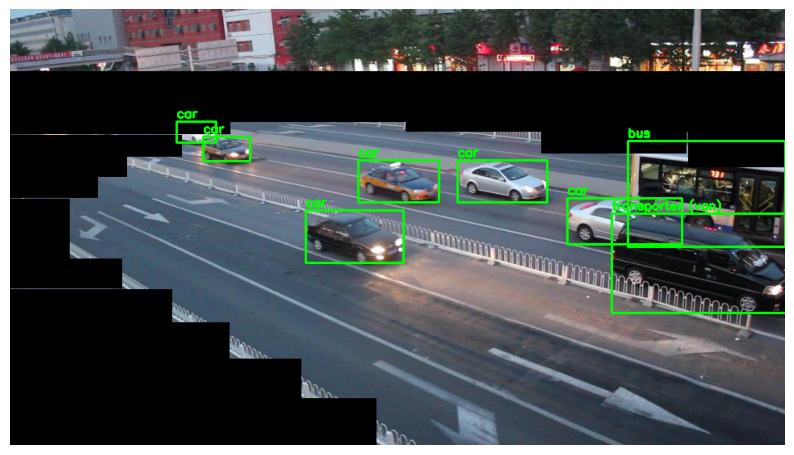

In [47]:
draw_random_image(new_img_dirs)

Выбрано изображение без аннотации (TRAIN): MVI_39761_img01377.jpg


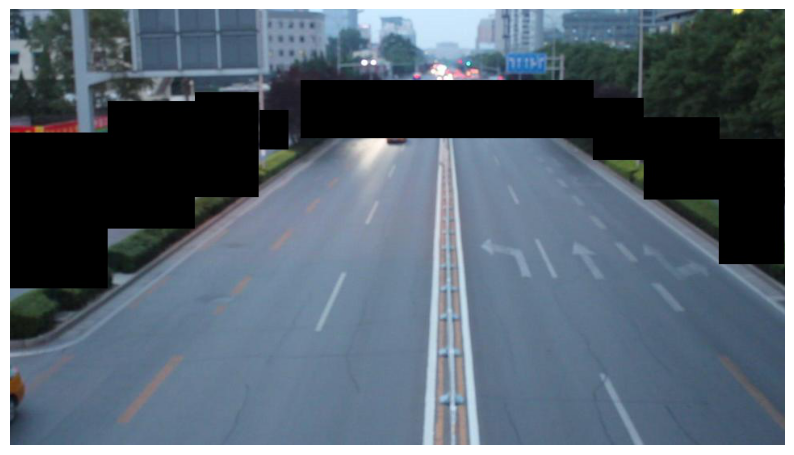

In [ ]:
def find_images_without_labels(image_dir, label_dir):
    images = set(f for f in os.listdir(image_dir) if f.endswith(".jpg"))
    labels = set(f.replace(".txt", ".jpg") for f in os.listdir(label_dir) if f.endswith(".txt"))
    
    return list(images - labels)

no_label_train = find_images_without_labels(new_img_dirs["TRAIN"], new_label_dirs["TRAIN"])
no_label_val = find_images_without_labels(new_img_dirs["VAL"], new_label_dirs["VAL"])

if no_label_train:
    random_image = random.choice(no_label_train)
    image_path = os.path.join(new_img_dirs["TRAIN"], random_image)
    print(f"Выбрано изображение без аннотации (TRAIN): {random_image}")
elif no_label_val:
    random_image = random.choice(no_label_val)
    image_path = os.path.join(new_img_dirs["VAL"], random_image)
    print(f"Выбрано изображение без аннотации (VAL): {random_image}")
else:
    print("Не найдено изображений без аннотации")
    image_path = None

if image_path:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [50]:
def remove_images_without_labels(image_dir, label_dir):
    images = set(f for f in os.listdir(image_dir) if f.endswith(".jpg"))
    labels = set(f.replace(".txt", ".jpg") for f in os.listdir(label_dir) if f.endswith(".txt"))
    
    images_without_labels = images - labels

    for img in images_without_labels:
        img_path = os.path.join(image_dir, img)
        os.remove(img_path)

    print(f"Удалено {len(images_without_labels)} изображений без аннотаций в {image_dir}")

remove_images_without_labels(new_img_dirs["TRAIN"], new_label_dirs["TRAIN"])
remove_images_without_labels(new_img_dirs["VAL"], new_label_dirs["VAL"])

print("done")

Удалено 78 изображений без аннотаций в UA-DETRAC_UPD_ANN_NO_MASK_MIN/images/train
Удалено 10 изображений без аннотаций в UA-DETRAC_UPD_ANN_NO_MASK_MIN/images/val
done


In [57]:
len([f for f in os.listdir(new_img_dirs["TRAIN"]) if f.endswith(".jpg")]), \
len([f for f in os.listdir(new_label_dirs["TRAIN"]) if f.endswith(".txt")]), \
len([f for f in os.listdir(new_img_dirs["VAL"]) if f.endswith(".jpg")]), \
len([f for f in os.listdir(new_label_dirs["VAL"]) if f.endswith(".txt")])

(16553, 16553, 3359, 3359)

In [52]:
exist_labels(new_label_dirs)


Распределение классов: {0: 1430, 1: 2559, 2: 129784, 3: 17270, 4: 12555, 5: 1185}
